In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

from numba import jit

from dynesty import NestedSampler
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

from ultranest import ReactiveNestedSampler
from ultranest.plot import PredictionBand

### Data

In [2]:
df = pd.read_csv("data.csv")

In [3]:
def plot_data(ax, df):
    ax.errorbar(df.index, df["v"], yerr=df["v_err"], marker="o", linestyle="none")
    ax.axhline(0, color="gray", linestyle="dotted")
    ax.set_xticks(df.index)
    ax.set_xticklabels(df["id"])
    ax.set_xlim([-1, 10])
    ax.set_ylim([-60, 60])
    ax.set_ylabel(r"$\Delta v$ (km/s)")

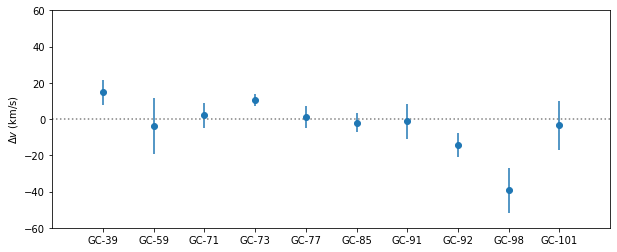

In [4]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_data(ax, df)
plt.show()

### Likelihood Function

In [5]:
@jit(nopython=True)
def expect(mu0, sigma0, mu1, sigma1):
    x2 = (mu1 - mu0)**2
    s2 = sigma0**2 + sigma1**2
    return np.exp(-0.5 * x2 / s2) / np.sqrt(2 * np.pi * s2)

In [6]:
def uniform_prior(x, x0, x1):
    return x0 + (x1 - x0) * x

def prior_transform(cube):
    params = cube.copy()
    params[0] = uniform_prior(cube[0], -50, 50) # mean
    params[1] = uniform_prior(cube[1], 0.1, 50) # log_sigma
    return params

def log_likelihood(params, v_meas=df["v"], v_meas_err=df["v_err"]):
    mean, log_sigma = params
    sigma = np.exp(log_sigma)
    
    value = 0
    for vi, vi_err in zip(v_meas, v_meas_err):
        value += np.log(expect(mean, sigma, vi, vi_err))
        
    return value

In [7]:
# quick test against scipy

def test_expect(mu0, sigma0, mu1, sigma1):
    d0 = scipy.stats.norm(mu0, sigma0)
    d1 = scipy.stats.norm(mu1, sigma1)
    reference_value = d0.expect(d1.pdf)
    test_value = expect(mu0, sigma0, mu1, sigma1)
    return np.isclose(test_value, reference_value)

assert test_expect(1, 10, 5, 50)

In [8]:
log_likelihood([0, 1]) # compile before timing
%timeit log_likelihood([0, 1])

32.1 µs ± 2.88 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Plot Functions

In [9]:
def plot_hist(ax, samples):
    _, log_sigma = np.transpose(samples)
    sigma = np.exp(log_sigma)
    
    print(f"sigma < {np.percentile(sigma, 90):.2f} km/s at 90% confidence")
    print(f"sigma < 10 km/s at {scipy.stats.percentileofscore(sigma, 10):.0f}% confidence")
    
    ax.hist(sigma, bins=np.linspace(0, 50, 41), density=True)
    ax.axvline(np.mean(sigma), color="C1")
    ax.axvline(np.percentile(sigma, 16), color="C1", linestyle="--")
    ax.axvline(np.percentile(sigma, 84), color="C1", linestyle="--")
    ax.axvline(np.percentile(sigma, 90), color="C2", linestyle="--")
    ax.set_xlabel(r"$\sigma$ (km/s)")
    ax.set_ylabel("Probability Density")

def plot_dist(ax, df, samples):
    mean, log_sigma = np.transpose(samples)
    sigma = np.exp(log_sigma)
    
    v = np.linspace(-80, 80, 500)
    for _, d in df.iterrows():
        ax.plot(v, scipy.stats.norm(d["v"], d["v_err"]).pdf(v), color="C0", alpha=0.5)
    
    band = PredictionBand(v)
    for loc, scale in zip(mean, sigma):
        band.add(scipy.stats.norm(loc, scale).pdf(v))
    band.shade(color="black", alpha=0.1)
    band.line(color="C1", linewidth=3)
    
    ax.set_xlabel(r"$\Delta v$ (km/s)")

## Example 1: Dynesty

In [10]:
n_dim = 2
sampler = NestedSampler(log_likelihood, prior_transform, n_dim)

In [11]:
sampler.run_nested()

3496it [00:04, 729.31it/s, +500 | bound: 7 | nc: 1 | ncall: 23366 | eff(%): 17.102 | loglstar:   -inf < -39.993 <    inf | logz: -46.145 +/-  0.145 | dlogz:  0.001 >  0.509]


In [12]:
result = sampler.results

In [13]:
result.summary()

Summary
nlive: 500
niter: 3496
ncall: 23366
eff(%): 17.102
logz: -46.145 +/-  0.145


In [14]:
#fig, ax = dyplot.runplot(result)

In [15]:
#fig, ax = dyplot.traceplot(results)

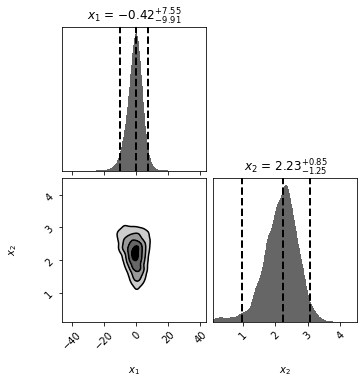

In [16]:
fg, ax = dyplot.cornerplot(result, show_titles=True)

In [17]:
samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
samples = dyfunc.resample_equal(samples, weights)

sigma < 16.18 km/s at 90% confidence
sigma < 10 km/s at 56% confidence


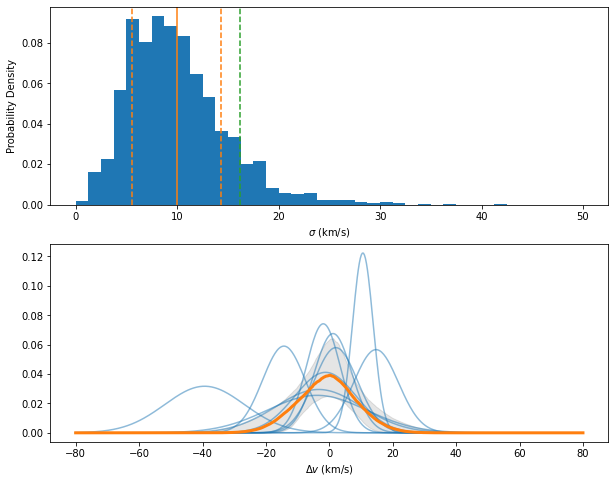

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_hist(ax[0], samples)
plot_dist(ax[1], df, samples)
plt.show()

## Example 2: UltraNest

In [19]:
sampler = ReactiveNestedSampler(["mean", "log_sigma"], log_likelihood, prior_transform)
result = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4e+01   [-40.0053..-40.0053]*| it/evals=4240/5967 eff=76.1631% N=400  
[ultranest] Likelihood function evaluations: 5996
[ultranest]   logZ = -46.05 +- 0.06796
[ultranest] Effective samples strategy satisfied (ESS = 1736.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.20, need <0.5)
[ultranest]   logZ error budget: single: 0.11 bs:0.07 tail:0.01 total:0.07 required:<0.50
[ultranest] done iterating.

logZ = -46.050 +- 0.112
  single instance: logZ = -46.050 +- 0.111
  bootstrapped   : logZ = -46.051 +- 0.111
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    mean                -0.8 +- 4.6
    log_sigma           2.18 +- 0.55


In [20]:
#sampler.plot_run()

In [21]:
#sampler.plot_trace()

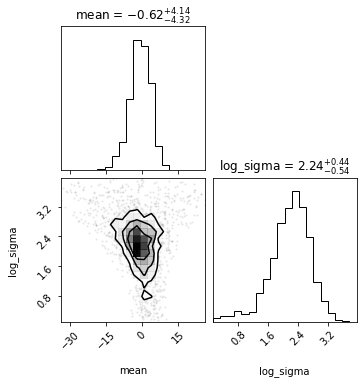

In [22]:
sampler.plot_corner()

sigma < 16.31 km/s at 90% confidence
sigma < 10 km/s at 55% confidence


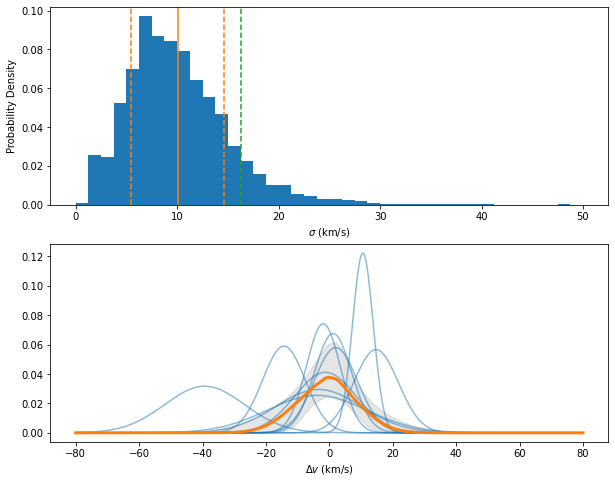

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_hist(ax[0], result["samples"])
plot_dist(ax[1], df, result["samples"])
plt.show()